In [5]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import Sequence
from tensorflow.keras.preprocessing import image

from tensorflow.keras.applications.xception import Xception, preprocess_input, decode_predictions


import os
import numpy as np
from sklearn.utils import class_weight
import matplotlib.pyplot as plt
import cv2

Useful functions and classes

In [3]:
# Function to count images in each class
def count_images_in_class(directory):
    class_counts = {}
    for class_name in os.listdir(directory):
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path):
            class_counts[class_name] = len(os.listdir(class_path))
    return class_counts

# Create a custom generator that balances classes using augmentation
class BalancedDataGenerator(Sequence):

    def __init__(self, generator, samples_to_generate, target_class):
        self.generator = generator
        self.samples_to_generate = samples_to_generate
        self.target_class = target_class
        self.class_idx = self.generator.class_indices[target_class]
        self.target_class_indices = [i for i, label in enumerate(self.generator.classes) if label == self.class_idx]
        
    def __len__(self):
        return len(self.generator) + self.samples_to_generate // self.generator.batch_size
    
    def __getitem__(self, idx):
        if idx < len(self.generator):
            return self.generator[idx]
        else:
            # Generate augmented samples for the minority class
            batch_x = []
            batch_y = []
            for _ in range(self.generator.batch_size):
                random_index = np.random.choice(self.target_class_indices)
                # Determine the batch index and the index within the batch
                batch_idx = random_index // self.generator.batch_size
                index_in_batch = random_index % self.generator.batch_size
                
                img, label = self.generator[batch_idx]
                
                # Append the specific image and label from the batch
                batch_x.append(img[index_in_batch])
                batch_y.append(label[index_in_batch])
                
            return np.array(batch_x), np.array(batch_y)
        
# Function to display generator information
def display_generator_info(generator, name):
    print(f"Displaying information for {name}:")
    batch_x, batch_y = next(generator)
    print(f"Batch size: {len(batch_x)}")
    print(f"Image shape: {batch_x[0].shape}")
    print(f"Labels shape: {batch_y.shape}")
    print(f"Labels: {batch_y}")
    print("\n")

# Function to plot images in a grid
def plot_images(images, labels, class_name, title=None):
    fig, axes = plt.subplots(4, 8, figsize=(20, 10))
    axes = axes.flatten()
    for img, ax, label in zip(images, axes, labels):
        ax.imshow(img)
        ax.axis('off')
        ax.set_title(class_name if label == 1 else 'OTHER')
    if title:
        plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()


In [9]:
# Define data directories
train_dir = 'image_data/train'
test_dir = 'image_data/test'

# Create an ImageDataGenerator instance with both augmentation and preprocessing
train_datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    preprocessing_function=preprocess_input  # Preprocessing function
)

test_datagen = ImageDataGenerator(preprocessing_function = preprocess_input)  # Preprocessing function 

# Load original training data without augmentation
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(299, 299),
    batch_size=32,
    class_mode='binary'
)

# Load testing data (without balancing)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(299, 299),
    batch_size=32,
    class_mode='binary'
)

Found 399 images belonging to 2 classes.
Found 65 images belonging to 2 classes.


In [45]:
print(train_generator.class_indices)
print(test_generator.class_indices)


{'LEA': 0, 'OTHER': 1}
{'LEA': 0, 'OTHER': 1}


In [11]:
# Count images in each class
class_counts = count_images_in_class(os.path.join(train_dir))
lea_count = class_counts.get('LEA', 0)
other_count = class_counts.get('OTHER', 0)

print(lea_count, other_count)
# Determine the number of samples needed for balancing
samples_to_generate = other_count - lea_count
print("Samples to generate in the training set:", samples_to_generate)

40 359
Samples to generate in the training set: 319


In [8]:
# Create the balanced generator for training

balanced_train_generator = BalancedDataGenerator(
    train_generator,
    samples_to_generate=samples_to_generate,
    target_class='LEA'
)

In [12]:
# Display information for balanced training generator
print("Balanced Training Generator Info:")
display_generator_info(iter(train_generator), "Balanced Training Generator")

# Display information for test generator
print("Test Generator Info:")
display_generator_info(iter(test_generator), "Test Generator")

## Print the number of batches in the balanced training generator
print(f"Number of batches in the balanced training generator: {len(train_generator)}")

# Print the number of batches in the test generator
print(f"Number of batches in the test generator: {len(test_generator)}")

Balanced Training Generator Info:
Displaying information for Balanced Training Generator:
Batch size: 32
Image shape: (299, 299, 3)
Labels shape: (32,)
Labels: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 0.]


Test Generator Info:
Displaying information for Test Generator:
Batch size: 32
Image shape: (299, 299, 3)
Labels shape: (32,)
Labels: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1. 1. 0. 0. 1. 0.
 1. 1. 1. 0. 1. 0. 1. 1.]


Number of batches in the balanced training generator: 13
Number of batches in the test generator: 3


In [ ]:
# Iterate over the batches of data from the balanced generator
for batch_x, batch_y in iter(train_generator):
    # Filter the images for the "LEA" class
    lea_indices = np.where(batch_y == 0)[0]
    lea_images = batch_x[lea_indices]

    # Display the images
    for i in range(lea_images.shape[0]):
        plt.subplot(1, lea_images.shape[0], i+1)
        plt.imshow(lea_images[i])
        plt.axis('off')

    plt.show()

    # break  # Uncomment this line if you want to process only the first batch

In [143]:
# Assuming test_generator is an instance of ImageDataGenerator
class_counts = train_generator.classes
num_lea_images = np.sum(class_counts == 0)
print(f"Number of images in the balanced training generator for the 'LEA' class: {num_lea_images}")

Number of images in the balanced training generator for the 'LEA' class: 40


In [13]:
# Assuming `train_generator` is your data generator
class_labels = train_generator.classes  # Get class labels from the generator
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(class_labels),
    y=class_labels
)

# Convert to a dictionary format as required by Keras
class_weights = {i: weight for i, weight in enumerate(class_weights)}
print(class_weights)

{0: 4.9875, 1: 0.5557103064066853}


In [15]:
# Load pre-trained model and fine-tune
base_model = Xception(weights='imagenet', include_top=False, input_shape=(299, 299, 3))

# Freeze the convolutional base
for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', 'precision'])

# Train the model
results = model.fit(train_generator, validation_data=test_generator, epochs=25, shuffle = True)

# Unfreeze the convolutional base
for layer in base_model.layers:
    layer.trainable = True

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', 'precision'])

# Train the model
results = model.fit(train_generator, validation_data=test_generator, epochs=25, shuffle = True)

Epoch 1/25


c:\Users\zakmins\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


13/13 ━━━━━━━━━━━━━━━━━━━━ 105s 7s/step - accuracy: 0.7970 - loss: 0.5072 - precision: 0.9166 - val_accuracy: 0.7231 - val_loss: 0.4341 - val_precision: 0.7231
Epoch 2/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 95s 7s/step - accuracy: 0.8993 - loss: 0.2123 - precision: 0.8974 - val_accuracy: 0.7846 - val_loss: 0.3712 - val_precision: 0.7705
Epoch 3/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 97s 7s/step - accuracy: 0.9715 - loss: 0.1200 - precision: 0.9761 - val_accuracy: 0.7846 - val_loss: 0.3738 - val_precision: 0.7705
Epoch 4/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 96s 7s/step - accuracy: 0.9679 - loss: 0.0836 - precision: 0.9783 - val_accuracy: 0.7846 - val_loss: 0.3639 - val_precision: 0.7705
Epoch 5/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 96s 7s/step - accuracy: 0.9881 - loss: 0.0553 - precision: 0.9882 - val_accuracy: 0.8769 - val_loss: 0.2118 - val_precision: 0.8679
Epoch 6/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 95s 7s/step - accuracy: 0.9875 - loss: 0.0438 - precision: 0.9879 - val_accuracy: 0.8154 - val_loss: 0.4017 - val_precisio

In [17]:
# Save the model
model.save('lea_classifier_XC.keras')

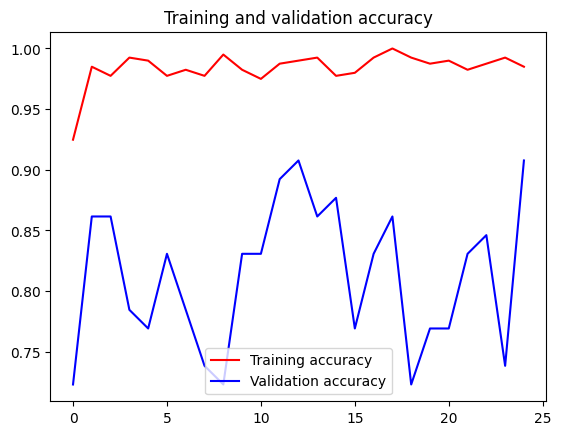

<Figure size 640x480 with 0 Axes>

In [34]:
acc = results.history['accuracy']
val_acc = results.history['val_accuracy']
loss = results.history['loss']
val_loss = results.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()



plt.show()

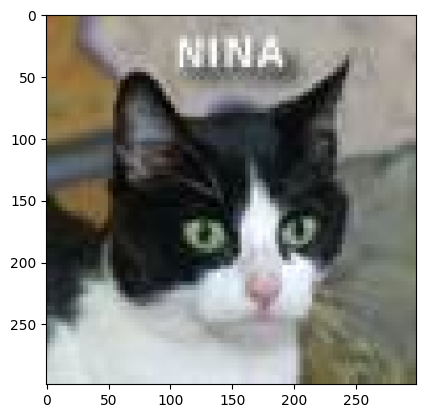

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step
Image name:  image_data/test/OTHER\304.png
Image label:  [[1]]
Predicted probability: [[1.]]
It is not LEA!


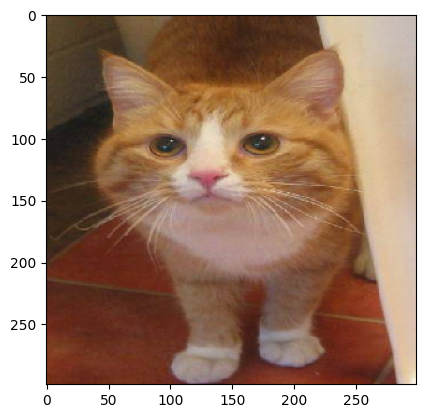

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step
Image name:  image_data/test/OTHER\311.png
Image label:  [[1]]
Predicted probability: [[1.]]
It is not LEA!


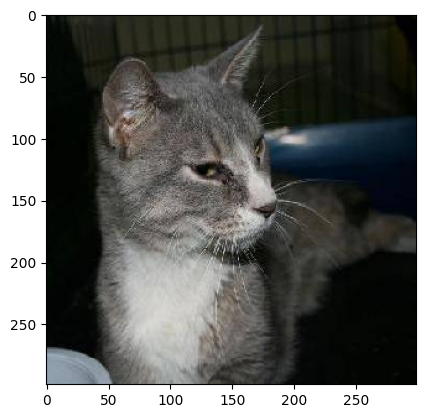

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step
Image name:  image_data/test/OTHER\312.png
Image label:  [[1]]
Predicted probability: [[1.]]
It is not LEA!


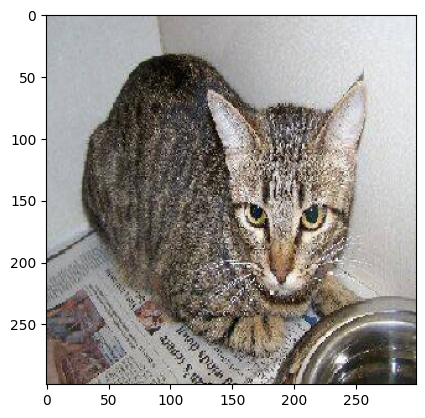

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step
Image name:  image_data/test/OTHER\315.png
Image label:  [[1]]
Predicted probability: [[0.9999749]]
It is not LEA!


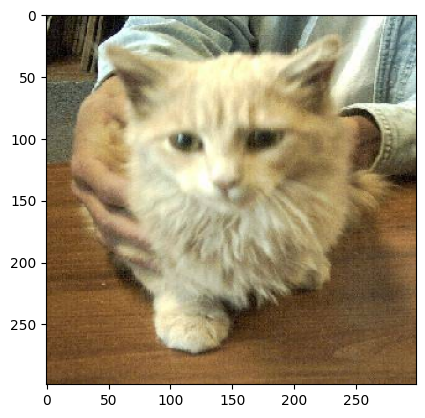

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step
Image name:  image_data/test/OTHER\317.png
Image label:  [[1]]
Predicted probability: [[1.]]
It is not LEA!


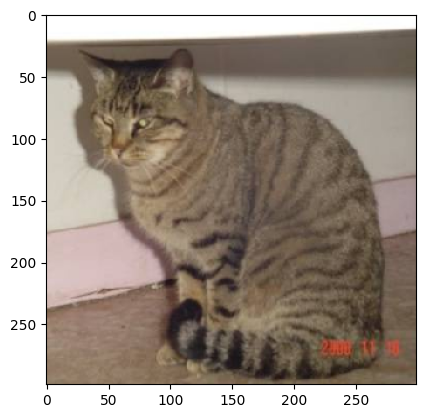

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step
Image name:  image_data/test/OTHER\320.png
Image label:  [[1]]
Predicted probability: [[1.]]
It is not LEA!


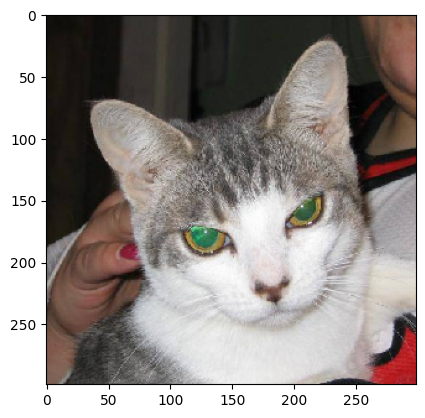

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step
Image name:  image_data/test/OTHER\321.png
Image label:  [[1]]
Predicted probability: [[1.]]
It is not LEA!


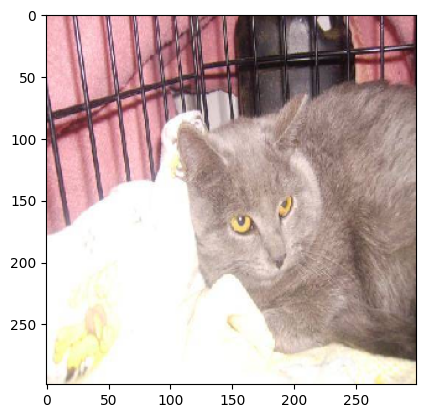

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step
Image name:  image_data/test/OTHER\330.png
Image label:  [[1]]
Predicted probability: [[1.]]
It is not LEA!


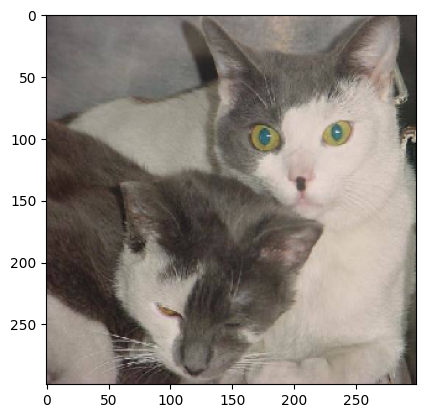

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step
Image name:  image_data/test/OTHER\331.png
Image label:  [[1]]
Predicted probability: [[1.]]
It is not LEA!


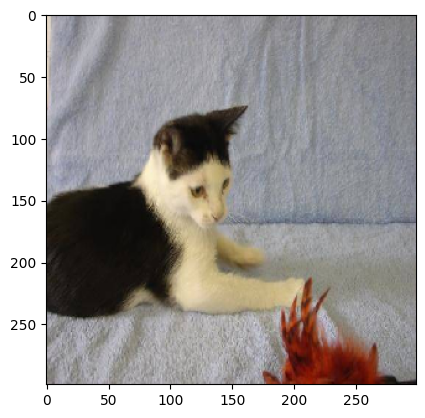

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step
Image name:  image_data/test/OTHER\332.png
Image label:  [[1]]
Predicted probability: [[1.]]
It is not LEA!


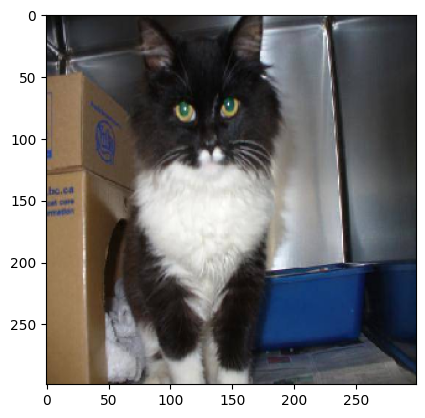

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step
Image name:  image_data/test/OTHER\333.png
Image label:  [[1]]
Predicted probability: [[0.9999999]]
It is not LEA!


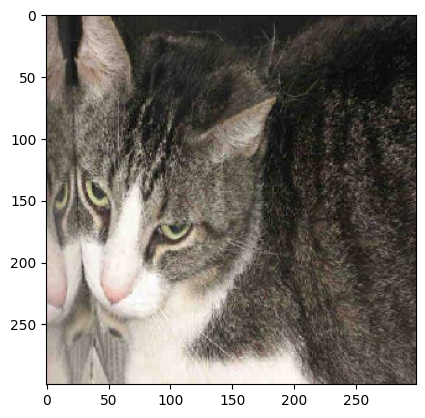

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step
Image name:  image_data/test/OTHER\336.png
Image label:  [[1]]
Predicted probability: [[1.]]
It is not LEA!


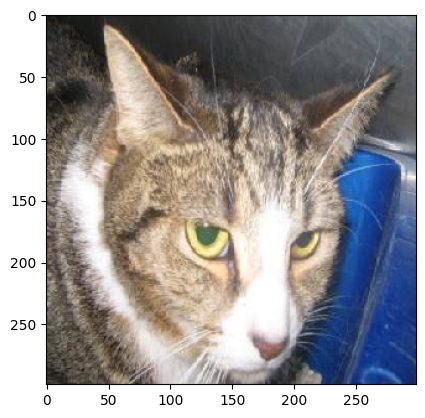

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step
Image name:  image_data/test/OTHER\343.png
Image label:  [[1]]
Predicted probability: [[1.]]
It is not LEA!


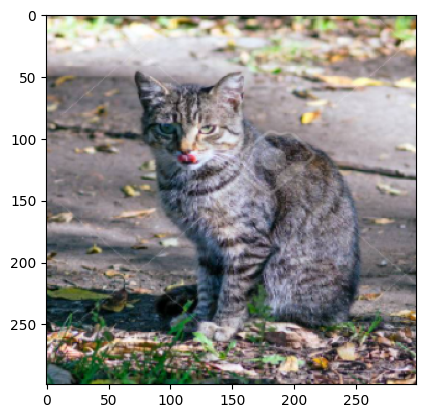

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step
Image name:  image_data/test/OTHER\353.png
Image label:  [[1]]
Predicted probability: [[1.]]
It is not LEA!


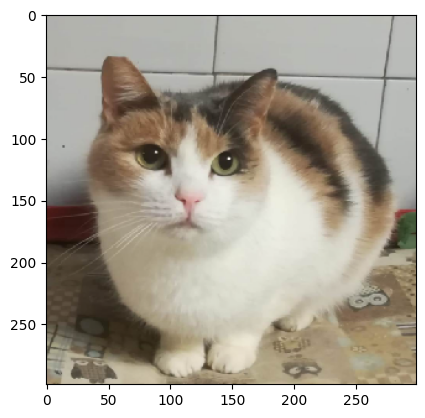

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step
Image name:  image_data/test/OTHER\354.png
Image label:  [[1]]
Predicted probability: [[0.99999976]]
It is not LEA!


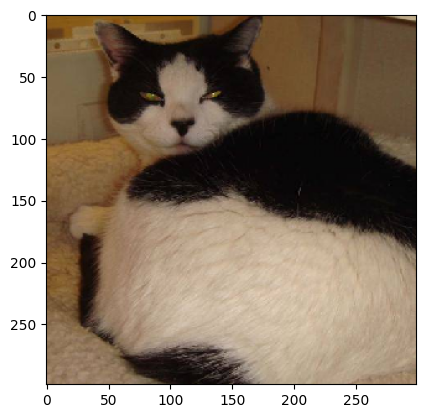

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step
Image name:  image_data/test/OTHER\363.png
Image label:  [[1]]
Predicted probability: [[1.]]
It is not LEA!


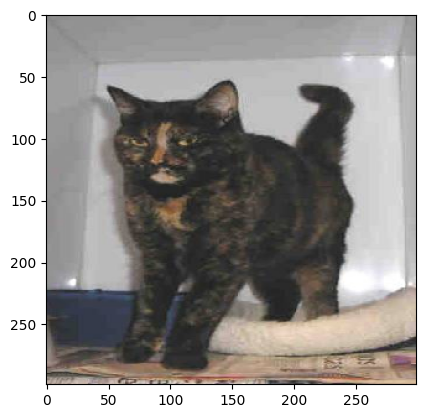

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step
Image name:  image_data/test/OTHER\364.png
Image label:  [[1]]
Predicted probability: [[0.9999577]]
It is not LEA!


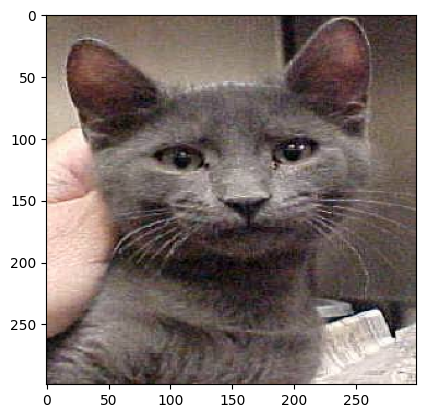

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step
Image name:  image_data/test/OTHER\371.png
Image label:  [[1]]
Predicted probability: [[1.]]
It is not LEA!


In [106]:
# Set the directory path
directory = 'image_data/test/OTHER'

# Get the list of image files in the directory
image_files = [os.path.join(directory, f) for f in os.listdir(directory) if f.endswith('.jpg') or f.endswith('.png')]

# Iterate over the image files
for image_file in image_files:
    # Load the image
    img = image.load_img(image_file, target_size=(299, 299))
    
    # Convert the image to a NumPy array
    x = image.img_to_array(img)
    x = preprocess_input(x)
    # Add an extra dimension to the array
    x = np.expand_dims(x, axis=0)
    
    # Display the image
    plt.imshow(img)
    plt.show()
    
    # Predict the class label
    images = np.vstack([x])
    probability = model.predict(images)
    classes = (model.predict(images) > 0.5).astype('int32')
    
    # Print the file name and predicted class label
    print('Image name: ', image_file)
    print('Image label: ', classes)
    print('Predicted probability:', probability)
    
    # Print the predicted class label

    # Print the predicted class label
    if classes == 0:
        print('It is LEA!')
    else:
        print('It is not LEA!')

In [101]:
lea_image = image.load_img('image_data/test/LEA/20240115_124516.jpg', target_size = (299, 299))
lea_image = image.img_to_array(lea_image)
lea_image.shape

(299, 299, 3)

In [102]:
lea_image = np.expand_dims(lea_image, axis = 0)
lea_image.shape

(1, 299, 299, 3)

In [103]:
lea_image = preprocess_input(lea_image)
probability = model.predict(lea_image)
# Predict the class label
predicted_class = (model.predict(lea_image) > 0.5).astype('int32')
if predicted_class == 0:
    print('It is LEA!')
    print('Predicted class probability:', probability)
else:
    print('It is not LEA!')
    print('Predicted class probability:', probability)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step
It is LEA!
Predicted class probability: [[0.00183852]]


In [54]:
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(299, 299),
    batch_size=32,
    class_mode='binary'
)

results = model.evaluate(test_generator)

# Print all the metrics
for name, value in zip(model.metrics_names, results):
    print(f"{name}: {value}")

Found 36 images belonging to 2 classes.


c:\Users\zakmins\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 859ms/step - accuracy: 0.8264 - loss: 1.3828 - precision: 0.7424
loss: 1.3283774852752686
compile_metrics: 0.8333333134651184


In [83]:
pred_list = model.predict(test_generator)
print(pred_list)

ValueError: Unrecognized data type: x=[<keras.src.legacy.preprocessing.image.DirectoryIterator object at 0x000002684FA6D400>] (of type <class 'list'>)

2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 807ms/step
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


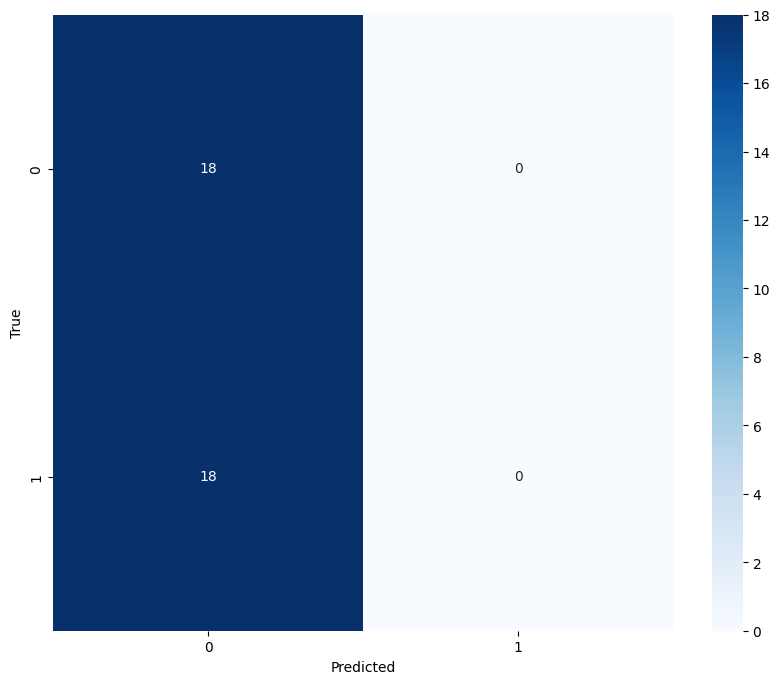

In [55]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_true = test_generator.classes
y_pred = np.argmax(model.predict(test_generator), axis=-1)

print(y_true)
print(y_pred)

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [56]:
print("Class distribution in test set:")
print(test_generator.class_indices)
print(np.bincount(test_generator.classes))

Class distribution in test set:
{'LEA': 0, 'OTHER': 1}
[18 18]


In [57]:
# Evaluate on the training set
results_train = model.evaluate(train_generator)
for name, value in zip(model.metrics_names, results_train):
    print(f"{name}: {value}")

13/13 ━━━━━━━━━━━━━━━━━━━━ 84s 6s/step - accuracy: 1.0000 - loss: 0.0017 - precision: 1.0000
loss: 0.0027370513416826725
compile_metrics: 1.0
